In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import h3

In [4]:
import sys, os, gc

sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from modules.config import *

## Feature Preparation

In [5]:
#read in trip data
trips_df = pd.read_parquet("../00_data/processed/trips_land_use.parquet")
trips_df.head(2)

,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number,trip_start,p_uid_start,p_bikes_start,lat_start,b_electric_lock,...,in_charged_flexzone_end,type,min_distance,duration,min_avg_speed,geometry_end,land_use_end,geometry_start,index_right,land_use_start
index,,,,,,,,,,,,,,,,,,,,,
1200,False,0,12,2019-01-20 20:58:00,23221,start,12118482,1,51.332653,True,...,True,trip,2.492277,17.0,8.796272,b'\x01\x01\x00\x00\x00K\x01\xc3\x90`\xabI@\xdb...,"Industrial, commercial, public, military and p...",b'\x01\x01\x00\x00\x00\n\xc9ib\x94\xaaI@\x91&8...,10,Other roads and associated land
2279,False,0,12,2019-01-21 08:42:00,23221,start,12120802,1,51.338741,True,...,False,trip,1.773600,13.0,8.185845,b'\x01\x01\x00\x00\x00\xb7\x9cKqU\xa9I@\xc6\xa...,"Industrial, commercial, public, military and p...",b'\x01\x01\x00\x00\x00\xd7\\{\xdb[\xabI@\xcb\x...,966,Continuous urban fabric (S.L. : > 80%)


In [6]:
trips = trips_df.loc[:, ['datetime_start', "b_number", 'lat_start', 'lng_start', 'datetime_end', 'lat_end', 'lng_end', 'min_distance','duration','min_avg_speed', 'land_use_start', 'land_use_end' ]]
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end
index,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,Other roads and associated land,"Industrial, commercial, public, military and p..."
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,Continuous urban fabric (S.L. : > 80%),"Industrial, commercial, public, military and p..."


In [7]:
del trips_df
gc.collect()

0

#### Land use data

In [8]:
#change land use to categorical
import json
with open('../00_data/processed/land_use_dict.json') as json_file:
    land_use_dict = json.load(json_file)

trips.land_use_start = trips.land_use_start.map(land_use_dict)
trips.land_use_end = trips.land_use_end.map(land_use_dict)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end
index,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2


#### Weather data

In [9]:
#round start time to hourly to merge weather data
trips["start_time_floored"] = trips["datetime_start"].dt.floor("H")
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,start_time_floored
index,,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2,2019-01-20 20:00:00
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2,2019-01-21 08:00:00


In [10]:
#get weather data 
weather = pd.read_parquet("../00_data/repo_data/weather_aggr.parquet")
weather = weather[weather["time_interval_length"]==1]
weather

,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length
MESS_DATUM,,,,,,,
2019-01-01 00:00:00,7.4,7.4,7.4,2.8,8.0,0.0,1
2019-01-01 01:00:00,7.7,7.7,7.7,2.9,8.0,0.0,1
2019-01-01 02:00:00,7.7,7.7,7.7,3.7,8.0,0.0,1
2019-01-01 03:00:00,7.7,7.7,7.7,3.2,8.0,0.0,1
2019-01-01 04:00:00,7.6,7.6,7.6,3.3,8.0,0.0,1
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2.8,2.8,2.8,2.3,1.0,0.0,1
2019-12-31 20:00:00,2.4,2.4,2.4,2.0,5.0,0.0,1
2019-12-31 21:00:00,2.7,2.7,2.7,2.3,7.0,0.0,1


In [11]:
trips = trips.merge(weather, left_on="start_time_floored", right_on="MESS_DATUM", how="left", right_index=False)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,start_time_floored,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2,2019-01-20 20:00:00,-6.4,-6.4,-6.4,0.6,1.0,0.0,1
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2,2019-01-21 08:00:00,-7.0,-7.0,-7.0,0.6,8.0,0.0,1


In [12]:
del weather
gc.collect()

20

#### Temporal features

In [13]:
#create time features
trips['hour'] = trips.start_time_floored.dt.hour
trips['weekday'] = trips.start_time_floored.dt.weekday
trips['month'] = trips.start_time_floored.dt.month
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length,hour,weekday,month
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,-6.4,-6.4,-6.4,0.6,1.0,0.0,1,20,6,1
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,-7.0,-7.0,-7.0,0.6,8.0,0.0,1,8,0,1


#### POIs

In [14]:
#get hexagon ids from trip locations
trips["hexagon_id_start"] = trips.apply(lambda loc: h3.geo_to_h3(lat=loc["lat_start"], lng=loc["lng_start"], resolution=9), axis=1)
trips["hexagon_id_end"] = trips.apply(lambda loc: h3.geo_to_h3(lat=loc["lat_end"], lng=loc["lng_end"], resolution=9), axis=1)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length,hour,weekday,month,hexagon_id_start,hexagon_id_end
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,-6.4,0.6,1.0,0.0,1,20,6,1,891f1a16487ffff,891f1a8ca53ffff
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,-7.0,0.6,8.0,0.0,1,8,0,1,891f1a8ca53ffff,891f1a8d93bffff


In [15]:
#read in poi data
hexagon_pois = pd.read_parquet(HEXAGON_WITH_POIS_PATH)
hexagon_pois = hexagon_pois[hexagon_pois["h3_res"]==9]
hexagon_pois.drop(columns=["h3_res", "hex_and_neighbors"], inplace=True)
hexagon_pois.head(2)

,hex,sustenance_poi,public_transport_poi,education_poi,arts_and_culture_poi,sports_poi
798,891f1a10d13ffff,0,3,0,0,0
799,891f1a10d8fffff,0,3,0,0,0


In [16]:
#merge hexagon pois with trip start
trips = trips.merge(hexagon_pois, left_on="hexagon_id_start", right_on="hex", how="left",right_index=False)
trips.rename(columns={"sustenance_poi": "sustenance_poi_start", 
                    "public_transport_poi": "public_transport_poi_start", 
                    "education_poi": "education_poi_start",
                    "arts_and_culture_poi": "arts_and_culture_poi_start",
                    "sports_poi": "sports_poi_start",
                    }, inplace=True)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,weekday,month,hexagon_id_start,hexagon_id_end,hex,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,6,1,891f1a16487ffff,891f1a8ca53ffff,891f1a16487ffff,13.0,12.0,8.0,0.0,1.0
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,0,1,891f1a8ca53ffff,891f1a8d93bffff,891f1a8ca53ffff,39.0,13.0,4.0,2.0,2.0


In [17]:
#merge hexagon pois with trip end
trips = trips.merge(hexagon_pois, left_on="hexagon_id_end", right_on="hex", how="left",right_index=False)
trips.rename(columns={"sustenance_poi": "sustenance_poi_end", 
                    "public_transport_poi": "public_transport_poi_end", 
                    "education_poi": "education_poi_end",
                    "arts_and_culture_poi": "arts_and_culture_poi_end",
                    "sports_poi": "sports_poi_end",
                    }, inplace=True)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,hex_y,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,12.0,8.0,0.0,1.0,891f1a8ca53ffff,39.0,13.0,4.0,2.0,2.0
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,13.0,4.0,2.0,2.0,891f1a8d93bffff,25.0,18.0,3.0,1.0,4.0


In [18]:
#drop unnecessary columns
trips.drop(columns=["time_interval_length", "hex_x", "hex_y"], inplace=True)

In [19]:
del hexagon_pois
gc.collect()

0

## Feature Selection

Now that we have merged all relevant data sets, we can take a look at which columns we can drop.

In [20]:
print(trips.columns)

Index(['datetime_start', 'b_number', 'lat_start', 'lng_start', 'datetime_end',
       'lat_end', 'lng_end', 'min_distance', 'duration', 'min_avg_speed',
       'land_use_start', 'land_use_end', 'start_time_floored',
       'min_temperature', 'max_temperature', 'mean_temperature',
       'mean_mean_wind_speed', 'mean_total_cloud_cover', 'sum_precipitation',
       'hour', 'weekday', 'month', 'hexagon_id_start', 'hexagon_id_end',
       'sustenance_poi_start', 'public_transport_poi_start',
       'education_poi_start', 'arts_and_culture_poi_start', 'sports_poi_start',
       'sustenance_poi_end', 'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end'],
      dtype='object')


In [21]:
trips = trips.drop(columns=["start_time_floored", "datetime_start", "datetime_end", 'hexagon_id_start', 'hexagon_id_end', 'b_number', "max_temperature", "min_temperature"])
trips.head(2)

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,mean_temperature,...,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,13.0,12.0,8.0,0.0,1.0,39.0,13.0,4.0,2.0,2.0
1,51.338741,12.332891,51.322920,12.336262,1.773600,13.0,8.185845,3,2,-7.0,...,39.0,13.0,4.0,2.0,2.0,25.0,18.0,3.0,1.0,4.0


In [22]:
#shorten land_use for land_use_start
trips.land_use_start = trips.land_use_start.replace([3,6], 1)
trips.land_use_start = trips.land_use_start.replace([7,14,18,21,10,13,15,16,19], 0)
trips["land_use_start"].value_counts()

1     237746
20    168985
2     109814
5      28655
12     21725
4       3795
9       2334
8        892
0        765
11       606
Name: land_use_start, dtype: int64

In [23]:
#shorten land_use for land_use_end
trips.land_use_end = trips.land_use_end.replace([3,6], 1)
trips.land_use_end = trips.land_use_end.replace([7,14,18,21,10,13,15,16,19], 0)
trips["land_use_end"].value_counts()

1     252678
20    152264
2     111351
5      30090
12     19707
4       4199
9       2446
8        907
11       861
0        814
Name: land_use_end, dtype: int64

In [24]:
land_use_dummy_start = pd.get_dummies(trips.land_use_start, prefix="land_use_start")
trips = pd.concat([trips, land_use_dummy_start], axis=1)
trips

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,mean_temperature,...,land_use_start_0,land_use_start_1,land_use_start_2,land_use_start_4,land_use_start_5,land_use_start_8,land_use_start_9,land_use_start_11,land_use_start_12,land_use_start_20
0,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,0,0,0,0,0,0,0,0,0,1
1,51.338741,12.332891,51.322920,12.336262,1.773600,13.0,8.185845,1,2,-7.0,...,0,1,0,0,0,0,0,0,0,0
2,51.322920,12.336262,51.326782,12.339472,0.483625,4.0,7.254374,2,1,-6.6,...,0,0,1,0,0,0,0,0,0,0
3,51.327149,12.339131,51.326231,12.368130,2.016257,7.0,17.282201,1,20,-5.0,...,0,1,0,0,0,0,0,0,0,0
4,51.326178,12.368146,51.336542,12.374882,1.243092,9.0,8.287279,1,20,-4.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575312,51.332227,12.364663,51.329031,12.339150,1.806729,20.0,5.420186,5,1,1.3,...,0,0,0,0,1,0,0,0,0,0
575313,51.329036,12.339146,51.320720,12.343097,0.963941,5.0,11.567288,1,1,0.6,...,0,1,0,0,0,0,0,0,0,0
575314,51.320889,12.343077,51.332253,12.366026,2.033302,13.0,9.384471,1,1,4.2,...,0,1,0,0,0,0,0,0,0,0
575315,51.332209,12.366046,51.320916,12.343747,1.993139,12.0,9.965696,1,1,7.0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
land_use_dummy_end = pd.get_dummies(trips.land_use_end, prefix="land_use_end")
trips = pd.concat([trips, land_use_dummy_end], axis=1)
trips

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,mean_temperature,...,land_use_end_0,land_use_end_1,land_use_end_2,land_use_end_4,land_use_end_5,land_use_end_8,land_use_end_9,land_use_end_11,land_use_end_12,land_use_end_20
0,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,0,0,1,0,0,0,0,0,0,0
1,51.338741,12.332891,51.322920,12.336262,1.773600,13.0,8.185845,1,2,-7.0,...,0,0,1,0,0,0,0,0,0,0
2,51.322920,12.336262,51.326782,12.339472,0.483625,4.0,7.254374,2,1,-6.6,...,0,1,0,0,0,0,0,0,0,0
3,51.327149,12.339131,51.326231,12.368130,2.016257,7.0,17.282201,1,20,-5.0,...,0,0,0,0,0,0,0,0,0,1
4,51.326178,12.368146,51.336542,12.374882,1.243092,9.0,8.287279,1,20,-4.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575312,51.332227,12.364663,51.329031,12.339150,1.806729,20.0,5.420186,5,1,1.3,...,0,1,0,0,0,0,0,0,0,0
575313,51.329036,12.339146,51.320720,12.343097,0.963941,5.0,11.567288,1,1,0.6,...,0,1,0,0,0,0,0,0,0,0
575314,51.320889,12.343077,51.332253,12.366026,2.033302,13.0,9.384471,1,1,4.2,...,0,1,0,0,0,0,0,0,0,0
575315,51.332209,12.366046,51.320916,12.343747,1.993139,12.0,9.965696,1,1,7.0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
trips.isna().sum()

lat_start                         0
lng_start                         0
lat_end                           0
lng_end                           0
min_distance                      0
duration                          0
min_avg_speed                     0
land_use_start                    0
land_use_end                      0
mean_temperature                  0
mean_mean_wind_speed              0
mean_total_cloud_cover            0
sum_precipitation                 0
hour                              0
weekday                           0
month                             0
sustenance_poi_start          21515
public_transport_poi_start    21515
education_poi_start           21515
arts_and_culture_poi_start    21515
sports_poi_start              21515
sustenance_poi_end            22521
public_transport_poi_end      22521
education_poi_end             22521
arts_and_culture_poi_end      22521
sports_poi_end                22521
land_use_start_0                  0
land_use_start_1            

As we can see, we dont have POI data for all hexagons so we need to fill those values with 0.

In [27]:
trips.fillna(0, inplace=True)

## Scaling

In [28]:
X = trips
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head(2)

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,mean_temperature,...,land_use_end_0,land_use_end_1,land_use_end_2,land_use_end_4,land_use_end_5,land_use_end_8,land_use_end_9,land_use_end_11,land_use_end_12,land_use_end_20
0,-0.212523,-0.200862,0.275928,-1.590408,0.492869,-0.155883,0.435483,1.494933,-0.598992,-2.820773,...,-0.037641,-0.884963,2.041249,-0.085745,-0.234921,-0.039737,-0.065343,-0.038714,-0.188332,-0.599931
1,0.267498,-1.588969,-0.973949,-1.445143,-0.047056,-0.199435,0.273372,-0.769857,-0.598992,-2.895896,...,-0.037641,-0.884963,2.041249,-0.085745,-0.234921,-0.039737,-0.065343,-0.038714,-0.188332,-0.599931


In [29]:
X_scaled_df.to_feather( "../00_data/processed/X_scaled_df.feather")

## Hard Clustering: K-means++

In [40]:
X_cluster_features = X_scaled_df.drop(columns=["land_use_start", "land_use_end"])

In [41]:
# defining the maximum quantity of centers
k_max = 10

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = KMeans(n_clusters=k + 1, random_state=4711)
    model.fit(X_cluster_features)
    clusters.append(k + 1)
    losses.append(model.inertia_)

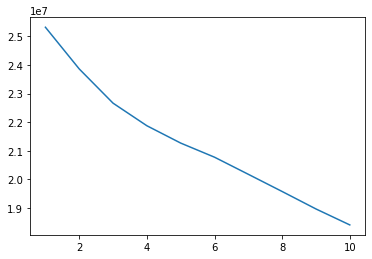

In [42]:
# plot losses
plt.plot(clusters, losses)
plt.show()

We select a number of 5 clustered based on the loss curve. 

In [43]:
# run again with k=4
four_means = KMeans(n_clusters=5, random_state=4711)
four_means.fit(X_cluster_features)
four_means.predict(X_cluster_features)

array([0, 1, 0, ..., 1, 1, 0])

In [67]:
X.groupby("cluster").mean()

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,mean_temperature,...,land_use_end_2,land_use_end_4,land_use_end_5,land_use_end_8,land_use_end_9,land_use_end_11,land_use_end_12,land_use_end_20,poi_cluster,location_cluster
cluster,,,,,,,,,,,,,,,,,,,,,
0,51.332874,12.370187,51.333376,12.370291,1.858582,33.263301,6.917968,12.811951,6.963849,16.266212,...,0.170234,0.010163,0.053120,0.002480,0.005960,0.001990,0.001846,0.286710,0.130683,1.968606
1,51.334582,12.370022,51.334030,12.369959,1.795473,33.616387,6.858626,1.030835,6.681411,15.838054,...,0.165429,0.009303,0.048138,0.001739,0.005028,0.002015,0.002026,0.273817,0.201533,1.951950
2,51.335981,12.374116,51.340662,12.377251,2.004731,25.018890,8.358453,7.596280,6.968926,15.707980,...,0.321571,0.000000,0.056799,0.000000,0.000727,0.000000,0.178825,0.181435,1.002663,1.000000
3,51.344179,12.380869,51.339112,12.377415,1.949596,34.704321,7.415259,12.000000,6.935740,15.957866,...,0.169513,0.005724,0.050457,0.001339,0.003001,0.001016,0.026221,0.274536,1.766596,0.111855
4,51.339672,12.376236,51.335932,12.373533,1.656664,28.254361,6.939297,6.339705,7.019968,16.868715,...,0.171349,0.004983,0.054158,0.000922,0.002879,0.001070,0.019376,0.282338,1.978234,0.047832


In [64]:
# create dataframe with clusters, their size and the means of the features
clusters = four_means.cluster_centers_
#clusters = scaler.inverse_transform(clusters)
clusters_df = pd.DataFrame(clusters, columns=X_cluster_features.columns)
clusters_rounded_df = clusters_df.round(2)
clusters_rounded_df["size"] = X_scaled_df.groupby(four_means.labels_).size()
clusters_rounded_df.head(10)

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,...,land_use_end_1,land_use_end_2,land_use_end_4,land_use_end_5,land_use_end_8,land_use_end_9,land_use_end_11,land_use_end_12,land_use_end_20,size
0,-0.20,-0.08,-0.16,-0.07,0.02,0.02,-0.06,0.02,-0.01,-0.01,...,0.05,-0.06,0.03,0.00,0.02,0.03,0.01,-0.18,0.05,202016
1,-0.06,-0.08,-0.10,-0.09,-0.03,0.03,-0.08,-0.04,-0.05,0.00,...,0.10,-0.07,0.02,-0.02,0.00,0.01,0.01,-0.18,0.02,170260
2,0.05,0.08,0.42,0.21,0.13,-0.07,0.32,-0.05,0.02,0.01,...,-0.36,0.32,-0.09,0.02,-0.04,-0.05,-0.04,0.79,-0.19,93488
3,0.70,0.36,0.29,0.21,0.09,0.04,0.07,-0.02,0.04,0.03,...,0.06,-0.06,-0.02,-0.01,-0.01,-0.02,-0.01,-0.04,0.02,21662
4,0.34,0.17,0.04,0.06,-0.13,-0.03,-0.06,0.09,0.10,0.01,...,0.05,-0.06,-0.03,0.01,-0.02,-0.02,-0.01,-0.08,0.04,87891


In [44]:
# map cluster to data
X["cluster"] = four_means.labels_

In [45]:
# function for plotting comparing clusters in different features
def show_cluster_values(columns):
    fig, axs = plt.subplots(int(len(columns) / 2), 2)
    fig.set_size_inches(10, 10)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.violinplot(
            x=X["cluster"],
            y=X[col],
            data=X,
            palette="magma",
            ax=axs[plots_row][plots_col]
        )
        axs[plots_row][plots_col].set_xlabel("Cluster")
        axs[plots_row][plots_col].set_ylabel("".join(l.capitalize() + " " for l in col.replace("_"," ").split()))
        if plots_col == 1:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = 1
    plt.tight_layout()

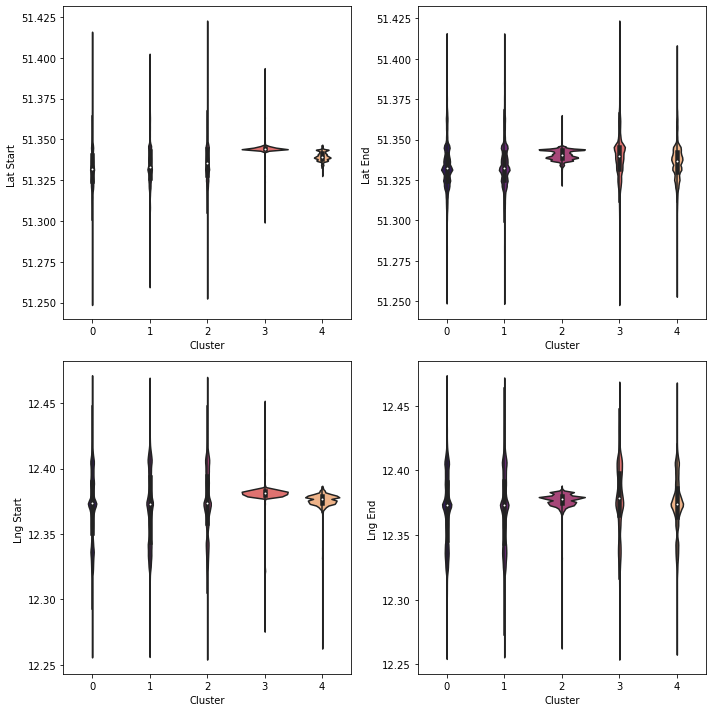

In [46]:
show_cluster_values(
    ["lat_start", "lat_end", "lng_start", "lng_end"]
)

Cluster 3 stadt centrum (um Thomaskirche) oder bahnhof?

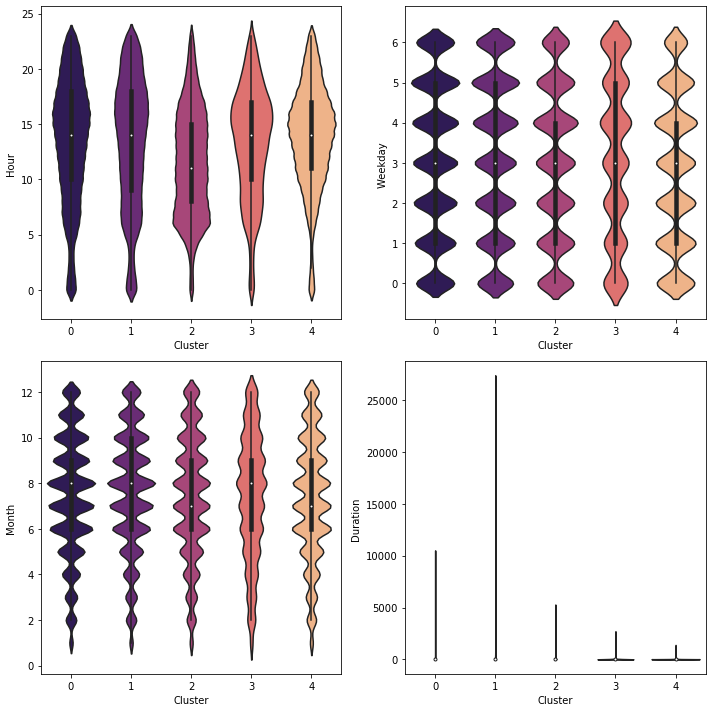

In [90]:
show_cluster_values(
    ['hour', 'weekday', 'month',"duration"]
)

- cluster 1 very long trips
- cluster 2 shows trips at rush hours and during the week
- Land use 12 is railways and associated land, maybe train station?, cluster 1 discontinous dense urban fabric
- cluster 2 goes to rail ways (work locations)
- 

In [88]:
land_use_clusters= X.groupby(["cluster", "land_use_start"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
land_use_clusters

,cluster,0,1,2,4,5,8,9,11,12,20
0,0,682,0,60179,3263,18103,804,1978,0,10,116997
1,1,0,169735,0,0,0,0,0,525,0,0
2,2,83,43269,13946,532,4734,88,279,81,53,30423
3,3,0,0,0,0,0,0,0,0,21662,0
4,4,0,24742,35689,0,5818,0,77,0,0,21565


In [89]:
land_use_clusters.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(2)

,0,1,2,4,5,8,9,11,12,20
0,0.0,0.00,0.30,0.02,0.09,0.0,0.01,0.0,0.0,0.58
1,0.0,1.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00
2,0.0,0.46,0.15,0.01,0.05,0.0,0.00,0.0,0.0,0.33
3,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.0,0.00
4,0.0,0.28,0.41,0.00,0.07,0.0,0.00,0.0,0.0,0.25


In [84]:
land_use_clusters= X.groupby(["cluster", "land_use_end"]).size().unstack(fill_value=0).reset_index().rename_axis(None, axis=1)
land_use_clusters

,cluster,0,1,2,4,5,8,9,11,12,20
0,0,422,94020,34390,2053,10731,501,1204,402,373,57920
1,1,310,83544,28166,1584,8196,296,856,343,345,46620
2,2,0,24367,30063,0,5310,0,68,0,16718,16962
3,3,20,10122,3672,124,1093,29,65,22,568,5947
4,4,62,40625,15060,438,4760,81,253,94,1703,24815


In [86]:
land_use_clusters.iloc[:, 1:].apply(lambda x: x / x.sum(), axis=1).round(2)

,0,1,2,4,5,8,9,11,12,20
0,0.0,0.47,0.17,0.01,0.05,0.0,0.01,0.0,0.00,0.29
1,0.0,0.49,0.17,0.01,0.05,0.0,0.01,0.0,0.00,0.27
2,0.0,0.26,0.32,0.00,0.06,0.0,0.00,0.0,0.18,0.18
3,0.0,0.47,0.17,0.01,0.05,0.0,0.00,0.0,0.03,0.27
4,0.0,0.46,0.17,0.00,0.05,0.0,0.00,0.0,0.02,0.28


In [71]:
{y: x for x, y in land_use_dict.items()}

{1: 'Discontinuous dense urban fabric (S.L. : 50% -  80%)',
 2: 'Industrial, commercial, public, military and private units',
 3: 'Continuous urban fabric (S.L. : > 80%)',
 4: 'Sports and leisure facilities',
 5: 'Green urban areas',
 6: 'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
 7: 'Arable land (annual crops)',
 8: 'Pastures',
 9: 'Land without current use',
 10: 'Forests',
 11: 'Water',
 12: 'Railways and associated land',
 13: 'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
 14: 'Mineral extraction and dump sites',
 15: 'Isolated structures',
 16: 'Herbaceous vegetation associations (natural grassland, moors...)',
 17: 'Discontinuous very low density urban fabric (S.L. : < 10%)',
 18: 'Construction sites',
 19: 'Fast transit roads and associated land',
 20: 'Other roads and associated land',
 21: 'Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)',
 22: 'Wetlands'}

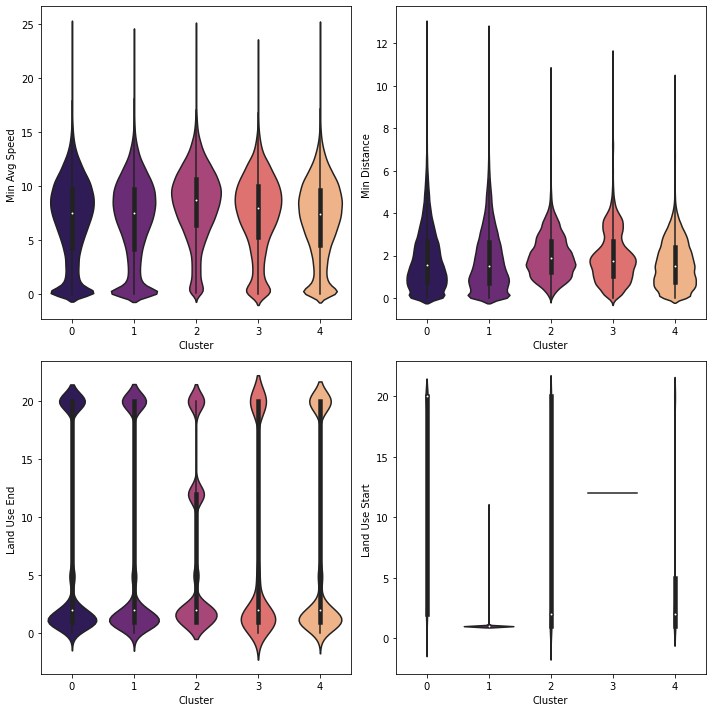

In [92]:
show_cluster_values(
    ['min_avg_speed', 'min_distance', 'land_use_end',"land_use_start"])


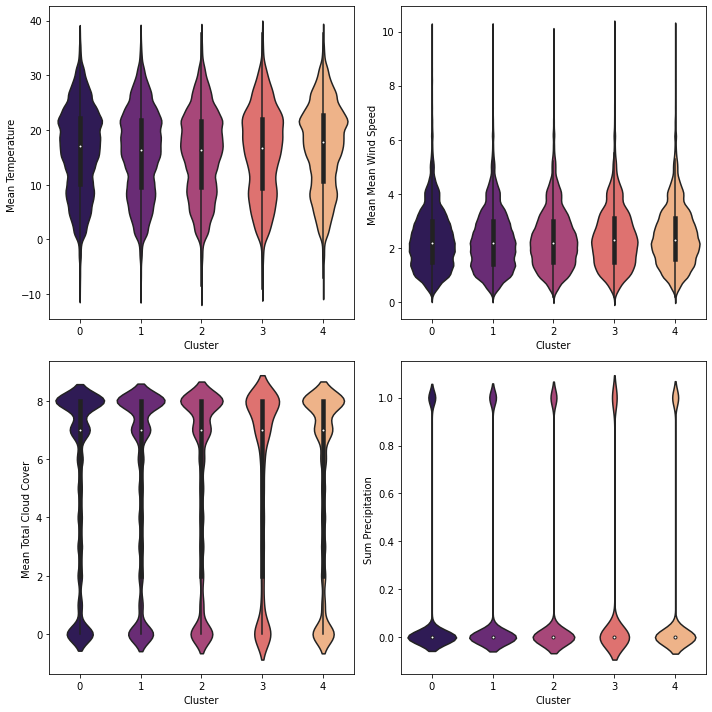

In [48]:
show_cluster_values(
    ['mean_temperature', 'mean_mean_wind_speed', 'mean_total_cloud_cover',
       'sum_precipitation']
)

not interesting

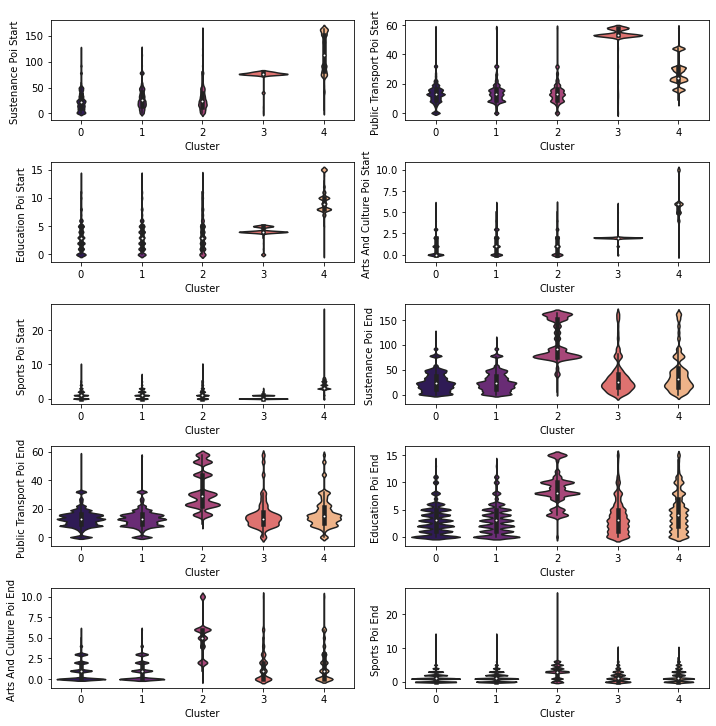

In [49]:
show_cluster_values(['sustenance_poi_start',
       'public_transport_poi_start', 'education_poi_start',
       'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
       'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end'])

- cluster 3 has high public transdport start count which supports asumptio nthat this are railway
- cluster 2 (pendler cluster) lots of trips to public transport (as a compliment to public transport for commuting?)
- cluster 2 also to arts and culture, sustenance, education and sports (working places or leisure activities)
- cluster 3 nd 4 also more often to arts and cluture, education and sustanance 

## K-means++ partial clustering

In [ ]:
# defining the maximum quantity of centers
def find_k(X_scaled,k_max):

    clusters = []
    losses = []

    # train each model and save losses
    for k in range(k_max):
        model = KMeans(n_clusters=k + 1, random_state=4711)
        model.fit(X_scaled)
        clusters.append(k + 1)
        losses.append(model.inertia_)

    plt.plot(clusters, losses)
    plt.show()

In [ ]:

def cluster_plots(columns, x1, x2, cluster_column):
    fig, axs = plt.subplots(x1, x2)
    fig.set_size_inches(10, 10)
    plots_row = 0
    plots_col = 0
    for col in columns:
        sns.violinplot(
            x=X[cluster_column],
            y=X[col],
            data=X,
            palette="magma",
            ax=axs[plots_row][plots_col]
        )
        axs[plots_row][plots_col].set_xlabel("Cluster")
        axs[plots_row][plots_col].set_ylabel("".join(l.capitalize() + " " for l in col.replace("_"," ").split()))
        if plots_col == 1:
            plots_row = plots_row + 1
            plots_col = 0
        else:
            plots_col = 1
    plt.tight_layout()

In [ ]:
def run_kmeans(X_scaled, n, name):
    k_means = KMeans(n_clusters=n, random_state=4711)
    k_means.fit(X_scaled)
    k_means.predict(X_scaled)

    X[name] = k_means.labels_

### Duration

In [129]:
X_duration = X_scaled_df.loc[:,["min_distance", "duration","min_avg_speed"]]


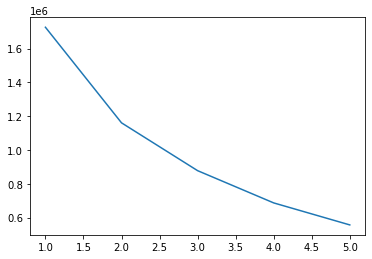

In [132]:
find_k(X_duration,5)

In [134]:
run_kmeans(X_duration, 3, "duration_cluster")

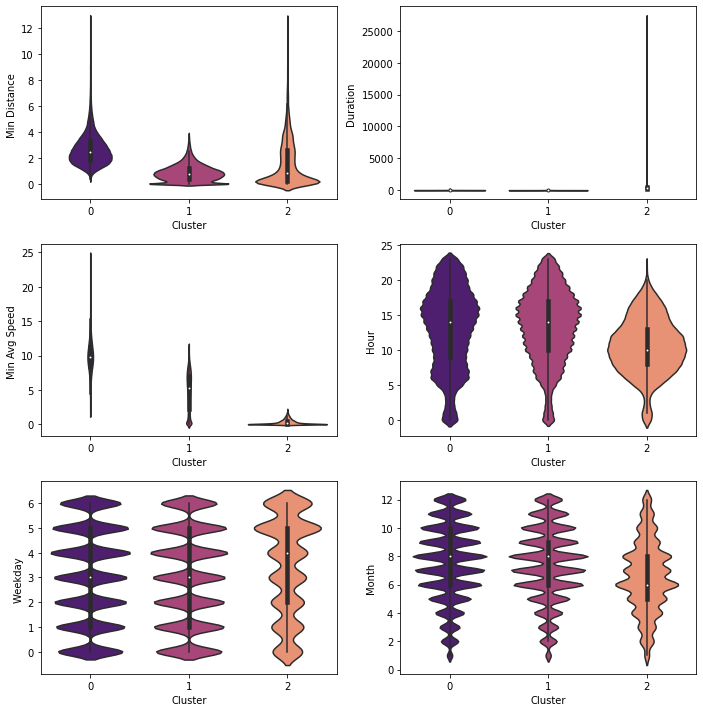

In [136]:
cluster_plots(["min_distance", "duration","min_avg_speed","hour", "weekday", "month"], 3,2, "duration_cluster")

### Location

In [137]:
X_scaled_df.columns

Index(['lat_start', 'lng_start', 'lat_end', 'lng_end', 'min_distance',
       'duration', 'min_avg_speed', 'land_use_start', 'land_use_end',
       'mean_temperature', 'mean_mean_wind_speed', 'mean_total_cloud_cover',
       'sum_precipitation', 'hour', 'weekday', 'month', 'sustenance_poi_start',
       'public_transport_poi_start', 'education_poi_start',
       'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
       'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end', 'land_use_start_0',
       'land_use_start_1', 'land_use_start_2', 'land_use_start_4',
       'land_use_start_5', 'land_use_start_8', 'land_use_start_9',
       'land_use_start_11', 'land_use_start_12', 'land_use_start_20',
       'land_use_end_0', 'land_use_end_1', 'land_use_end_2', 'land_use_end_4',
       'land_use_end_5', 'land_use_end_8', 'land_use_end_9', 'land_use_end_11',
       'land_use_end_12', 'land_use_end_20'],
      dtype='object')

In [56]:
X_loc = X_scaled_df.loc[:,["lat_start", "lat_end","lng_start", "lng_end", 'sustenance_poi_start',
       'public_transport_poi_start', 'education_poi_start',
       'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
       'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end', 'land_use_start_0',
       'land_use_start_1', 'land_use_start_2', 'land_use_start_4',
       'land_use_start_5', 'land_use_start_8', 'land_use_start_9',
       'land_use_start_11', 'land_use_start_12', 'land_use_start_20',
       'land_use_end_0', 'land_use_end_1', 'land_use_end_2', 'land_use_end_4',
       'land_use_end_5', 'land_use_end_8', 'land_use_end_9', 'land_use_end_11',
       'land_use_end_12', 'land_use_end_20']]

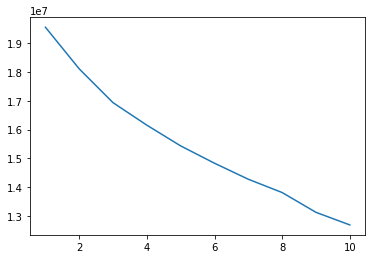

In [139]:
find_k(X_loc,10)

In [57]:
run_kmeans(X_loc, 3, "location_cluster")

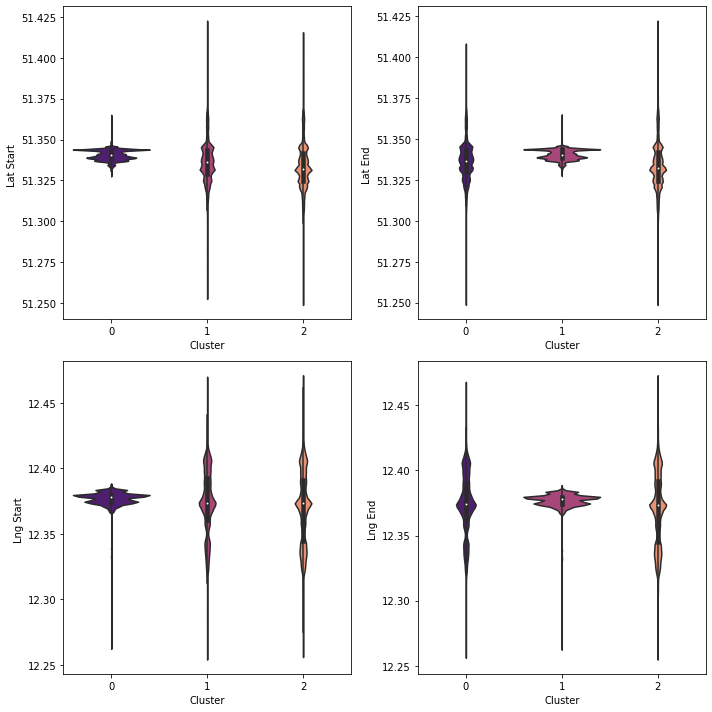

In [58]:
cluster_plots(["lat_start", "lat_end","lng_start", "lng_end"], 2,2, "location_cluster")

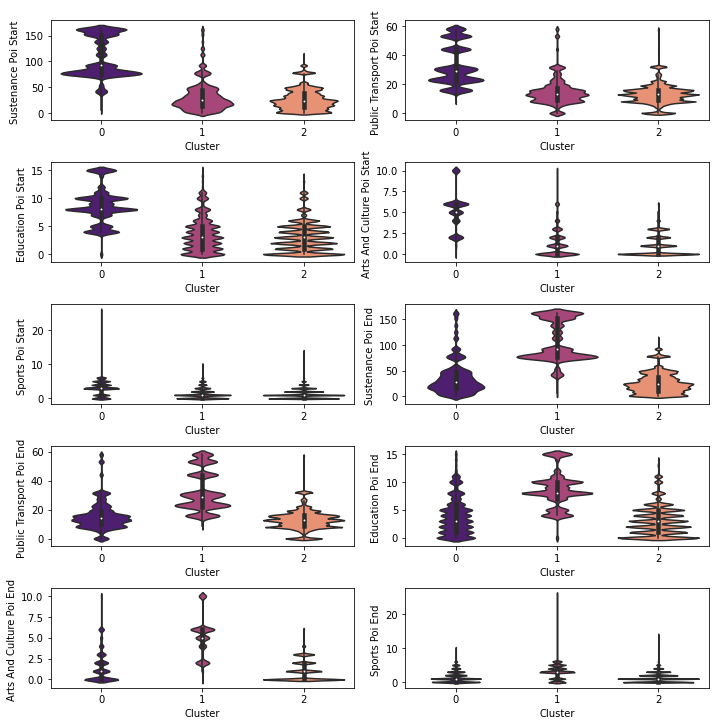

In [59]:
cluster_plots([ 'sustenance_poi_start',
       'public_transport_poi_start', 'education_poi_start',
       'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
       'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end'], 5,2, "location_cluster")

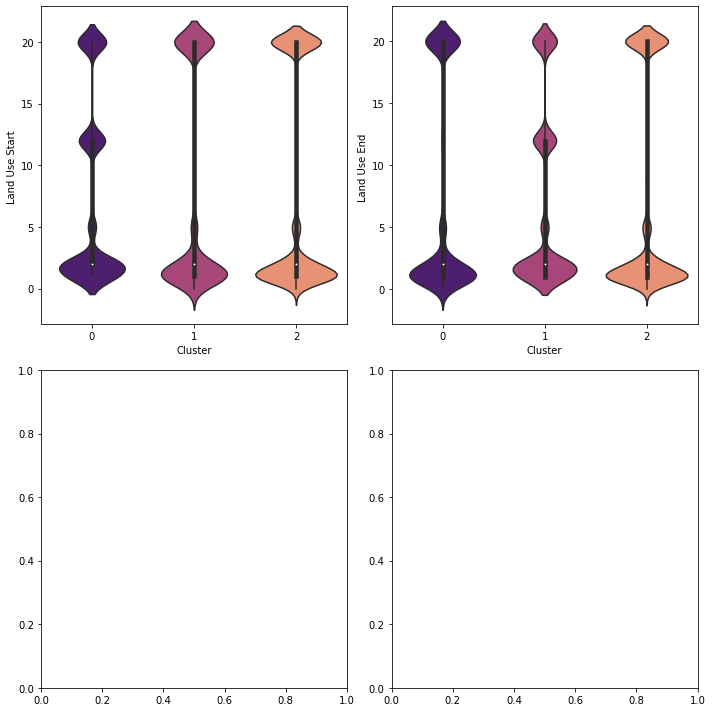

In [60]:
cluster_plots(["land_use_start", "land_use_end"], 2,2, "location_cluster")

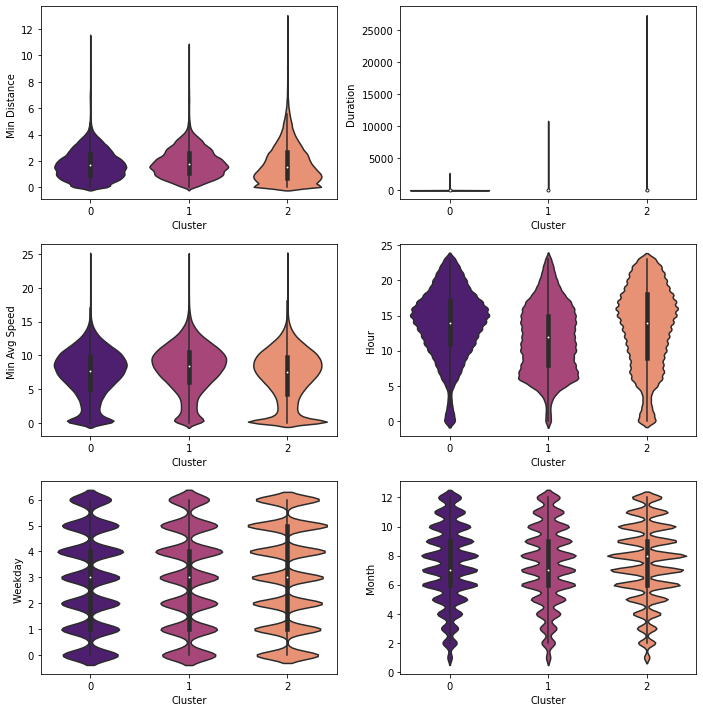

In [61]:
cluster_plots(['min_distance','duration', 'min_avg_speed', "hour", "weekday", "month"], 3,2, "location_cluster")

#### Latidude and Logitude

In [145]:
X_lat_lng = X_scaled_df.loc[:,["lat_start", "lat_end","lng_start", "lng_end"]]

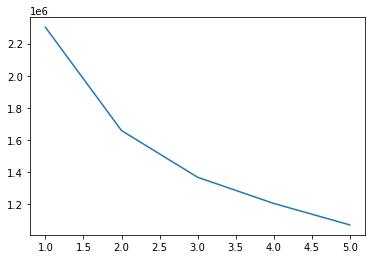

In [146]:
find_k(X_lat_lng,5)

In [147]:
run_kmeans(X_lat_lng, 3, "lat_lng_cluster")

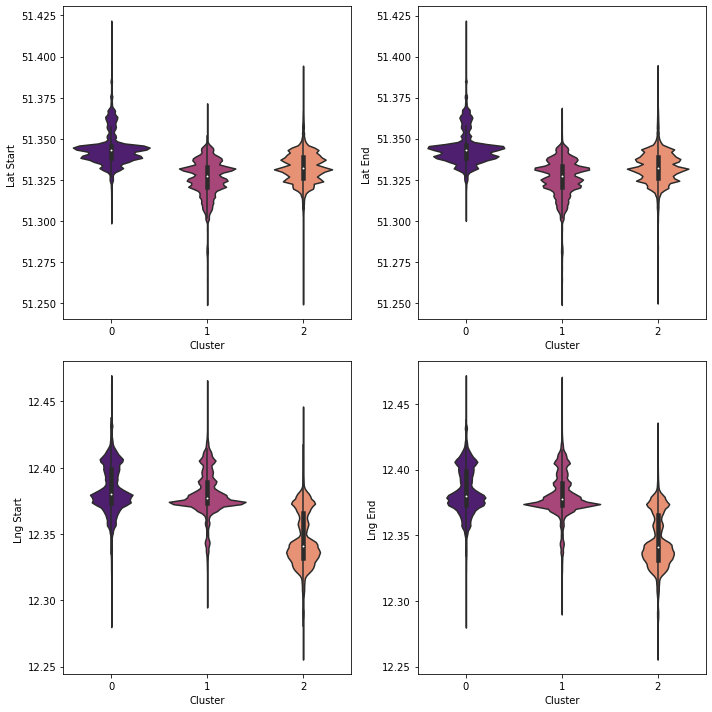

In [148]:
cluster_plots(["lat_start", "lat_end","lng_start", "lng_end"], 2,2, "lat_lng_cluster")

- cluster 3 different longitude
- cluster 1 an d 2 similar longitude slightly different latidude

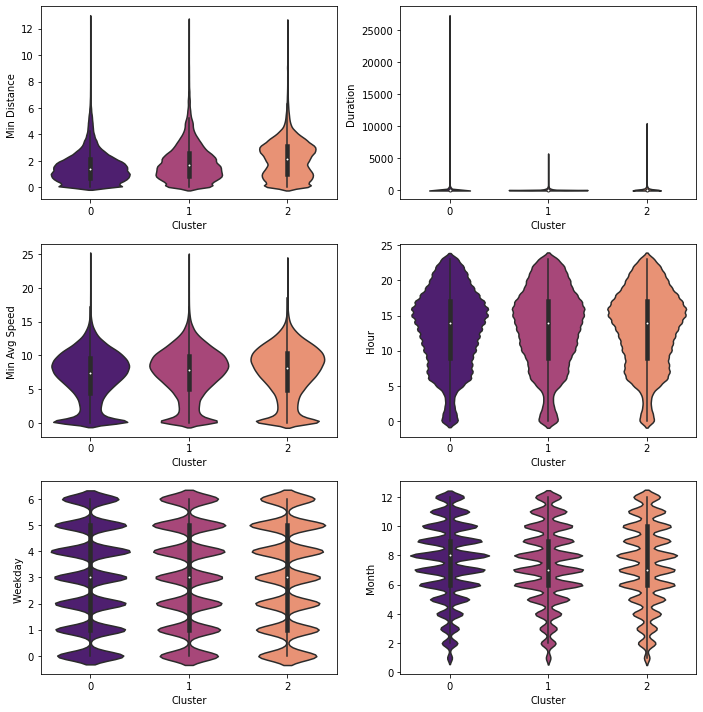

In [149]:
cluster_plots(['min_distance','duration', 'min_avg_speed', "hour", "weekday", "month"], 3,2, "lat_lng_cluster")

no strong differences, cluster 3 trips a bit more distance, cluster 1 a bit more time (focus on location of cluster 0 to maximize profit?). 

#### POI

In [33]:
X_poi = X_scaled_df.loc[:,['sustenance_poi_start',
       'public_transport_poi_start', 'education_poi_start',
       'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
       'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end']]

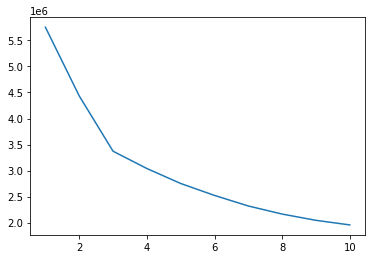

In [34]:
find_k(X_poi, 10)

In [35]:
run_kmeans(X_poi, 3, "poi_cluster")

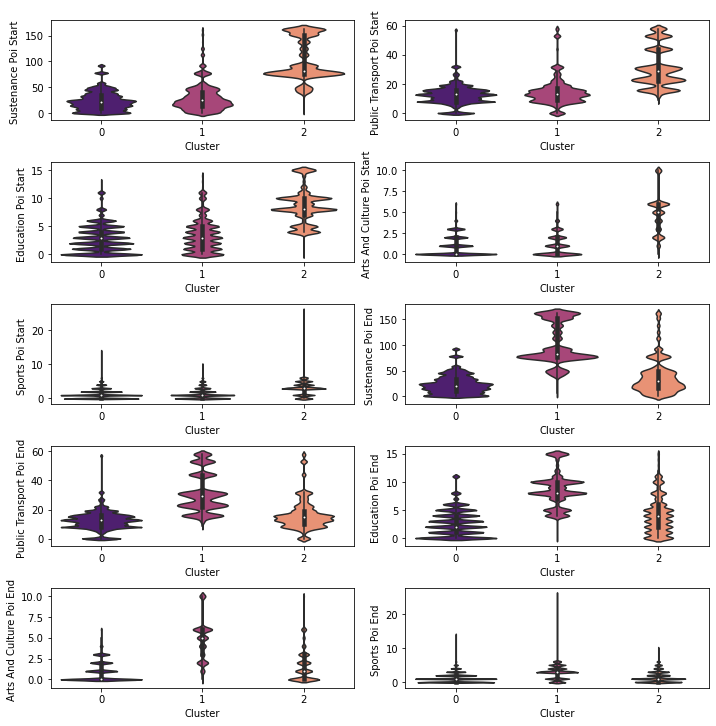

In [36]:
cluster_plots(['sustenance_poi_start',
       'public_transport_poi_start', 'education_poi_start',
       'arts_and_culture_poi_start', 'sports_poi_start', 'sustenance_poi_end',
       'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end'], 5,2, "poi_cluster")

#### Land use

In [38]:
X_land_use = X_scaled_df.loc[:,['land_use_start_0',
       'land_use_start_1', 'land_use_start_2', 'land_use_start_4',
       'land_use_start_5', 'land_use_start_8', 'land_use_start_9',
       'land_use_start_11', 'land_use_start_12', 'land_use_start_20',
       'land_use_end_0', 'land_use_end_1', 'land_use_end_2', 'land_use_end_4',
       'land_use_end_5', 'land_use_end_8', 'land_use_end_9', 'land_use_end_11',
       'land_use_end_12', 'land_use_end_20']]

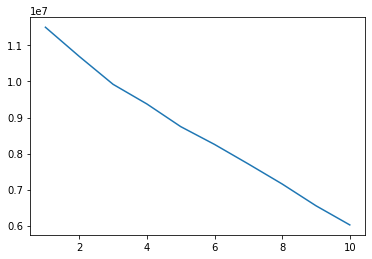

In [39]:
find_k(X_land_use,10)

In [ ]:
run_kmeans(X_land_use, 4, "land_use_cluster")

### Weather

In [150]:
X_weather = X_scaled_df.loc[:,['mean_temperature', 'mean_mean_wind_speed', 'mean_total_cloud_cover',
       'sum_precipitation']]

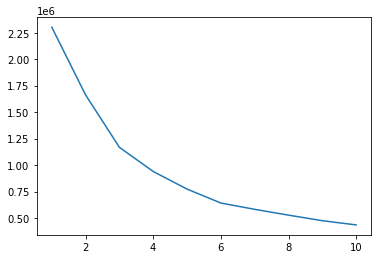

In [151]:
find_k(X_weather,10)

In [152]:
run_kmeans(X_weather, 3, "weather_cluster")

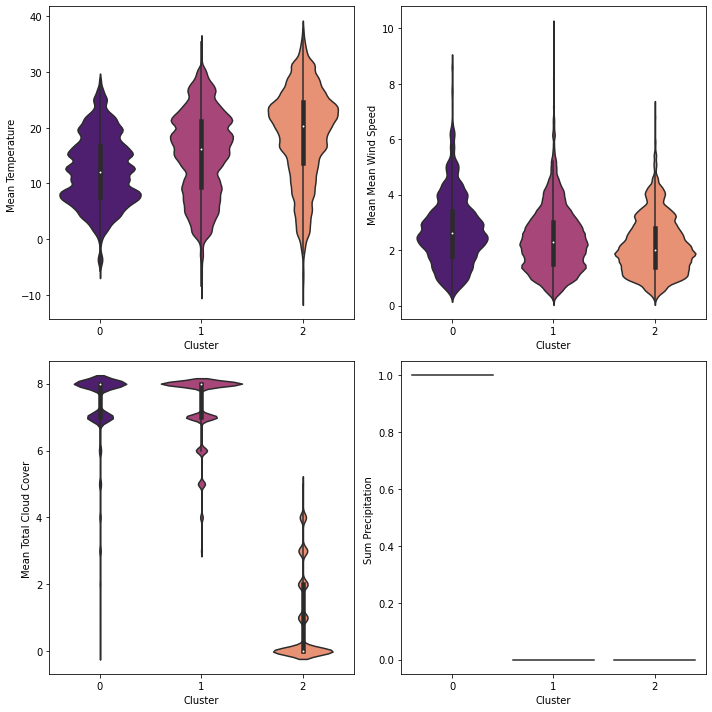

In [153]:
cluster_plots(["mean_temperature", 'mean_mean_wind_speed', 'mean_total_cloud_cover', 'sum_precipitation'], 2,2, "weather_cluster")

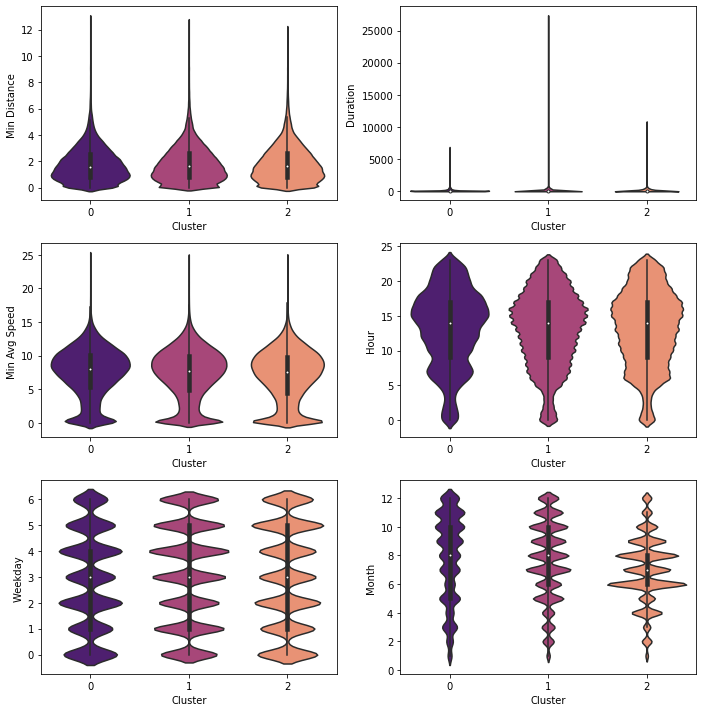

In [154]:
cluster_plots( ['min_distance',
       'duration', 'min_avg_speed', "hour", "weekday", "month"], 3,2, "weather_cluster")

- warm trips more over the day, longer, in summer months 